# Description du projet

Ce projet consiste à mettre sur place un modèle  capable de faire de la classification de texte (des critiques) de films selon une tonalité positive ou négative.

In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chargement des données

In [4]:
data_train_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/DeepLearning_ESTIA/Classification_Texte/train.parquet"
data_test_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/DeepLearning_ESTIA/Classification_Texte/test.parquet"
data_validation_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/DeepLearning_ESTIA/Classification_Texte/validation.parquet"


data_train = pd.read_parquet(data_train_path)


data_test = pd.read_parquet(data_test_path)


data_validation = pd.read_parquet(data_validation_path)


## Exploration des données

In [5]:
data_train.head()

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


In [6]:
print(data_train['review'])

0         Si vous cherchez du cinéma abrutissant à tous ...
1         Trash, re-trash et re-re-trash...! Une horreur...
2         Et si, dans les 5 premières minutes du film, l...
3         Mon dieu ! Quelle métaphore filée ! Je suis ab...
4         Premier film de la saga Kozure Okami, "Le Sabr...
                                ...                        
159995    Un rythme bien trop lent et un Ashton Kutcher ...
159996    Monsieur Duchovny vous êtes aussi piètre acteu...
159997    Complètement différent des films de la série C...
159998    Alors franchement pour le moment c'est le meil...
159999    Beur sur la ville réunit à lui même toutes les...
Name: review, Length: 160000, dtype: object


In [7]:
data_train[data_train['label'] == 0]

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
5,L'amnésie est un thème en or pour susciter le ...,0
...,...,...
159993,"Expliquez-moi l'interet de poser sa caméra, et...",0
159994,Denis Lavant en fait des caisses. La réalisatr...,0
159995,Un rythme bien trop lent et un Ashton Kutcher ...,0
159996,Monsieur Duchovny vous êtes aussi piètre acteu...,0


In [8]:
# Reviews count
data_train['label'].value_counts()

label
1    80587
0    79413
Name: count, dtype: int64

In [9]:
data_test['label'].value_counts()

label
0    10408
1     9592
Name: count, dtype: int64

## Prétraitement du texte

In [10]:
## Missing data
data_train.isnull().values.any()

False

## Définition du pipeline de prétraitement du texte

Pour les besoins du prétraitement des reviews nous appliqueront les étapes suivantes:

## 1) Tokenisation:
Diviser le texte en mots, phrases, ou sous-phrases significatifs, appelées tokens.

## 2) Suppression des caractères alphabétiques non numériques:
 Retirer les symboles, les caractères spéciaux et les emojis.

## 3) Suppression des stopwords:
Retirer les mots courants qui n'apportent de sens à la phrase.

Ces différentes étapes seront appliquées dans une fonction nommée "preprocess_text()"

In [ ]:
# Extract all non-alphabetic characters and store them in a set
non_alphab_chars = np.unique([char for review in data_train['review'] for char in review if not char.isalpha()])
print(non_alphab_chars)

[' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '[' '\\' ']'
 '^' '_' '`' '{' '|' '}' '~' '\x80' '\x8c' '\x91' '\x93' '\x94' '\x96'
 '\x97' '\x9c' '¡' '£' '¤' '¥' '¦' '§' '¨' '©' '«' '¬' '\xad' '®' '¯' '°'
 '±' '²' '³' '´' '·' '»' '½' '¾' '¿' '×' '̀' '́' '̈' '̧' '͜' '͡' '\u200b'
 '\u200d' '\u200e' '–' '—' '‘' '’' '‚' '“' '”' '•' '…' '\u202a' '\u202c'
 '′' '″' '‼' '€' '→' '∅' '∙' '►' '◄' '★' '☆' '☹' '☺' '♀' '♂' '♡' '♥' '♫'
 '⚠' '⚫' '✊' '✌' '✔' '❗' '❣' '❤' '➖' '⭐' '《' '》' '【' '】' '\ue045' '\ue046'
 '\uf04c' '\uf0ab' '\uf0e0' '\uf8ff' '️' '\ufeff' '�' '🇬' '🇮' '🇳' '🇷' '🌙'
 '🌟' '🌱' '🌳' '🌵' '🍀' '🍿' '🎀' '🎈' '🎞' '🎥' '🎧' '🎬' '🎶' '🏄' '🏻' '🏼' '🏽' '🏾'
 '👀' '👊' '👌' '👍' '👎' '👏' '👑' '👦' '👱' '👶' '👸' '💋' '💎' '💓' '💕' '💖' '💗' '💙'
 '💚' '💛' '💜' '💝' '💣' '💩' '💪' '💯' '📽' '🔥' '🔫' '🔴' '🔵' '🗡' '😀' '😁' '😂' '😃'
 '😄' '😅' '😆' '😇' '😈' '😉' '😊' '😋' '😍' '😎' '😏' '😑' '😒' '😔' '😕' '😖' '😗' '😘'
 '😚' '😜' '😟' '😠' '😡' '😢' '😤' '😥' '😧' '😨' '😩' '😪

In [11]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords
#stop_words = TfidfVectorizer(stop_words='english')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  # Tokeniser le texte
  tokens = word_tokenize(text)
    # Filtrer les tokens
  filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.isalnum()]
    # Rejoindre les tokens filtrés en une chaîne de caractères
  return " ".join(filtered_tokens)

# Appliquer la fonction preprocess_text à chaque élément de la colonne "review" sur les dataset
data_train["review"] = data_train["review"].apply(preprocess_text).tolist()
data_test["review"] = data_test["review"].apply(preprocess_text).tolist()
data_validation["review"] = data_validation["review"].apply(preprocess_text).tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
print(data_train["review"][3])

mon dieu quelle métaphore filée je suis abasourdi mais réellement ici une métaphore filée de que sa mère puisse à nouveau avoir une sexualité avec que son papounet chéri freud est aux anges et moi aussi sauf fait nul ce pas un disney channel original movie très intéressant faut dire est franchement vieux il date de 2000 autre millénaire les gens qui ont fait ce film pas connu le 11 septembre vous vous rendez compte toute cette candeur était encore possible époque bénie des dieux outre la blague retrouve déjà tous les poncifs du genre la meilleure amie noire qui devient la belle soeur qui au début énerve et puis finalement attache oh que mignon ça donne la nausée bref vous compris rien que du très classique ici mais ce qui la tête des actrices sérieusement physique rien que voir leur tête donne des envies de meurtre que je tente de réprimer bien entendu mais le pire le beau père une catastrophe censé être le personnage comique mais est au niveau kev adams de un sketch de norman drôle à 

# Définition des ensembles en entrainement, validation et test

In [13]:
X_train = data_train['review']
X_test = data_test['review']
X_val = data_validation['review']


y_train = data_train['label']
y_test = data_test['label']
y_val = data_validation['label']

In [21]:
print(np.array(y_train))

[0 0 0 ... 1 1 0]


## Baseline Bag of word

In [13]:
# Encodage labels

label_encoder = LabelEncoder()

y_train_encoder = label_encoder.fit_transform(y_train)
y_test_encoder = label_encoder.transform(y_test)
y_val_encoder = label_encoder.transform(y_val)

In [14]:
#Création du vecteur BOW
count_vect = CountVectorizer(max_features=10000)

X_train_bow = count_vect.fit_transform(X_train)
X_test_bow =  count_vect.transform(X_test)
X_val_bow = count_vect.transform(X_val)

In [15]:
print(X_train_bow.shape, X_test_bow.shape, X_val_bow.shape)

(160000, 10000) (20000, 10000) (20000, 10000)


In [16]:
count_vect.vocabulary_

{'si': 8332,
 'vous': 9620,
 'cherchez': 1580,
 'du': 2720,
 'cinéma': 1665,
 'tous': 9095,
 'les': 5072,
 'étages': 9924,
 'aucune': 768,
 'peur': 6645,
 'cliché': 1708,
 'en': 3100,
 'et': 3261,
 'moralement': 5766,
 'douteux': 2685,
 'paris': 6401,
 'love': 5213,
 'est': 3255,
 'fait': 3434,
 'pour': 6909,
 'productions': 7042,
 'besson': 1001,
 'via': 9449,
 'sa': 8051,
 'ont': 6227,
 'de': 2382,
 'quoi': 7332,
 'faire': 3427,
 'naître': 5997,
 'la': 4974,
 'encore': 3111,
 'une': 9318,
 'fois': 3652,
 'montrée': 5751,
 'comme': 1800,
 'capitale': 1345,
 'exotique': 3335,
 'mais': 5318,
 'attention': 753,
 'se': 8205,
 'dirige': 2541,
 'vers': 9430,
 'banlieue': 901,
 'trouve': 9236,
 'tout': 9096,
 'plein': 6758,
 'musulmans': 5851,
 'prêts': 7198,
 'sauter': 8134,
 'le': 5046,
 'dit': 2594,
 'va': 9353,
 'au': 766,
 'moins': 5707,
 'pouvoir': 6944,
 'apprécier': 607,
 'classique': 1701,
 'avec': 826,
 'jeune': 4803,
 'agent': 324,
 'aux': 811,
 'dents': 2419,
 'longues': 5174,
 '

## Logistic Regression Model

In [19]:
#Entrainement du modele
scaler = MaxAbsScaler()
X_train_bow_scaled = scaler.fit_transform(X_train_bow)
X_test_bow_scaled = scaler.transform(X_test_bow)

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train_bow_scaled, y_train_encoder)
y_pred_bow = clf_lr.predict(X_test_bow_scaled)

print(classification_report(y_test_encoder, y_pred_bow))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10408
           1       0.92      0.92      0.92      9592

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



Sur ces résultats de classification de texte avec le modèle logistic regression, il parvient à classer les critiques négatives (0) avec une précision de 93%. Et 92% de précision pour la classification de critiques positives.

## Random Forest Model

In [20]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_bow_scaled, y_train_encoder)
y_pred_bow1 = clf_rf.predict(X_test_bow_scaled)

#Rapport classification
print(classification_report(y_test_encoder, y_pred_bow1))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     10408
           1       0.88      0.87      0.87      9592

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



Avec le random forest, le modèle fait une classification sur les critiques négatives et positives avec une précision de 88%.

## Baseline TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.linear_model import LogisticRegression

# Création du vecteur TF-IDF
tfidf_vect = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
X_val_tfidf = tfidf_vect.transform(X_val)


In [22]:
scaler = MaxAbsScaler()
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

## Logistic Regression Model

In [23]:
#Entrainement du modele

clf_lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
clf_lr_tfidf.fit(X_train_tfidf_scaled, y_train_encoder)
y_pred_tfidf = clf_lr.predict(X_test_tfidf_scaled)

print(classification_report(y_test_encoder, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     10408
           1       0.90      0.92      0.91      9592

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



## RandomForest Model

In [24]:
# Entraînement du modèle
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf_scaled, y_train_encoder)

# Prédiction sur l'ensemble de test
y_pred_tfidf = rf_model.predict(X_test_tfidf_scaled)

print(classification_report(y_test_encoder, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     10408
           1       0.88      0.85      0.87      9592

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



## Encoding Text

In [ ]:
!pip install gensim

In [14]:
#from gensim.models import KeyedVectors
from gensim.models import KeyedVectors

# Charger le modèle Word2Vec pré-entraîné
path_word2vec_model = "https://embeddings.net/embeddings/frWiki_no_phrase_no_postag_500_cbow_cut10.bin"
word2vec_model = KeyedVectors.load_word2vec_format(path_word2vec_model, binary=True)


In [15]:
# Fonction pour encoder un texte en utilisant Word2Vec
def encode_text(texte, word2vec_model):
  words = texte.split()
  word_vectors = []
  for word in words:
    if word in word2vec_model:
      word_vectors.append(word2vec_model[word])
  if word_vectors:
    return np.mean(word_vectors, axis=0)
  else:
    return np.zeros(word2vec_model.vector_size)  # Retourne un vecteur nul si aucun mot n'est trouvé


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convertir les vecteurs encodés en séquences
sequences_train = [[word2vec_model.key_to_index[word] for word in texte.split() if word in word2vec_model.key_to_index] for texte in X_train]

sequences_test = [[word2vec_model.key_to_index[w] for w in texte.split() if w in word2vec_model.key_to_index] for texte in X_test]
# padding pour que toutes les séquences aient la même longueur
max_length = 200
X_train_padded = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')


In [17]:
print(X_train_padded)

[[   98   183  1330 ...     0     0     0]
 [    5    10  3448 ...     0     0     0]
 [    5    98    13 ...     0     0     0]
 ...
 [ 3050   237    21 ...     0     0     0]
 [  135    16     4 ...     0     0     0]
 [27575    17     2 ...     0     0     0]]


In [35]:
# Encoding vectors

vecteurs_encodes = []

# Parcourir chaque texte dans X_train et l'encoder
for texte in X_train:
  vecteur_encode = encode_text(texte, word2vec_model)
  vecteurs_encodes.append(vecteur_encode)

# Convertir la liste en un tableau numpy
X_train_encode = np.array(vecteurs_encodes)

In [37]:
print(X_train_encode)

[[ 0.07588162 -0.05959718 -0.04442843 ... -0.07676004 -0.0015312
   0.00287625]
 [ 0.07593109 -0.02515511  0.01650955 ... -0.11995534  0.0231497
  -0.00826255]
 [ 0.00216264  0.01282059  0.04653066 ... -0.05251545 -0.08790168
  -0.04229102]
 ...
 [ 0.12409429 -0.07841842  0.08392265 ... -0.06976635 -0.07339531
   0.03716455]
 [ 0.05148389 -0.04196196 -0.0502607  ... -0.10982496 -0.0043196
   0.16064417]
 [ 0.12659915 -0.02478202  0.02987253 ... -0.17532255 -0.01620881
  -0.00383387]]


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
      self.word2vec = word2vec

    def fit(self, X, y=None):
      return self

    def transform(self, X):

      return np.array([self.word2vec.get_mean_vector(doc_words) if doc_words else np.zeros(self.word2vec.vector_size) for doc_words in X])


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

rfc_w2v = Pipeline([
    ("vectorizer", MeanEmbeddingVectorizer(word2vec_model)),
    ("classifier", LogisticRegression())])

In [ ]:
#X_train_bow_arr = X_train_bow.toarray()


In [41]:
print(rfc_w2v)

Pipeline(steps=[('vectorizer',
                 MeanEmbeddingVectorizer(word2vec=<gensim.models.keyedvectors.KeyedVectors object at 0x7c837a59fe50>)),
                ('classifier', LogisticRegression())])


In [46]:
%%time
rfc_w2v.fit(X_train, y_train_encoder)

CPU times: user 1min 48s, sys: 1.97 s, total: 1min 50s
Wall time: 1min 59s


Pipeline(steps=[('vectorizer',
                 MeanEmbeddingVectorizer(word2vec=<gensim.models.keyedvectors.KeyedVectors object at 0x7c837a59fe50>)),
                ('classifier', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.56      0.44      0.49     10408
           1       0.51      0.63      0.56      9592

    accuracy                           0.53     20000
   macro avg       0.54      0.54      0.53     20000
weighted avg       0.54      0.53      0.53     20000



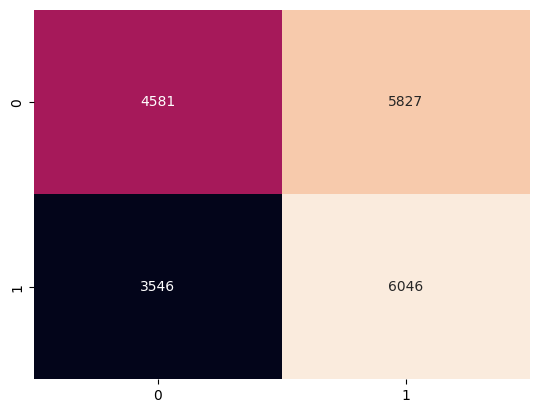

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rfc_w2v.predict(X_test)
print(classification_report(y_test_encoder, y_pred))
sns.heatmap(data=confusion_matrix(y_test_encoder, y_pred), annot=True, fmt="d", cbar=False, xticklabels=rfc_w2v.classes_, yticklabels=rfc_w2v.classes_);

# Reccurent Neural Network (LSTM)

## Preparing Embedding layer

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam


## Embedding layer

In [26]:
from keras.preprocessing.text import Tokenizer

# Tokenisation des textes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Récupération de l'index de mots
word_index = tokenizer.word_index

# Affichage de l'index de mots
print(word_index)


{'de': 1, 'et': 2, 'le': 3, 'la': 4, 'un': 5, 'à': 6, 'film': 7, 'les': 8, 'est': 9, 'qui': 10, 'en': 11, 'une': 12, 'des': 13, 'pas': 14, 'que': 15, 'du': 16, 'ce': 17, 'dans': 18, 'pour': 19, 'mais': 20, 'ne': 21, 'il': 22, 'plus': 23, 'avec': 24, 'très': 25, 'au': 26, 'se': 27, 'par': 28, 'tout': 29, 'bien': 30, 'je': 31, 'son': 32, 'sur': 33, 'sont': 34, 'même': 35, 'fait': 36, 'sans': 37, 'comme': 38, 'nous': 39, 'l': 40, 'peu': 41, 'si': 42, 'sa': 43, 'cette': 44, 'ou': 45, 'bon': 46, 'voir': 47, 'aussi': 48, 'ça': 49, 'scénario': 50, 'acteurs': 51, 'n': 52, 'ses': 53, 'vraiment': 54, 'faire': 55, 'scène': 56, 'rien': 57, 'trop': 58, 'aux': 59, 'histoire': 60, 'vous': 61, 'personnages': 62, 'être': 63, 'deux': 64, 'films': 65, 'fin': 66, 'mal': 67, 'grand': 68, 'cinéma': 69, 'où': 70, 'peut': 71, 'tous': 72, 'encore': 73, 'scènes': 74, 'entre': 75, 'fois': 76, 'car': 77, 'assez': 78, 'beaucoup': 79, 'elle': 80, 'reste': 81, 'mise': 82, 'vu': 83, 'lui': 84, 'ces': 85, 'quand': 86,

In [22]:
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

In [27]:
vocab_size = len(word_index) + 1
vocab_size

146572

In [28]:
from keras.optimizers import Adam

# Création du modèle LSTM
model = Sequential()

# Ajout de la couche d'embedding pour représenter les mots en vecteurs denses
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))

# Ajout de la couche LSTM avec 100 unités
model.add(LSTM(128))

# Ajout de la couche de sortie avec une unité et une fonction d'activation sigmoid pour la classification binaire
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle avec l'optimiseur Adam et la perte binaire_crossentropy pour la classification binaire
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          14657200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 14774577 (56.36 MB)
Trainable params: 14774577 (56.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Model training

lstm_model_history = model.fit(X_train_padded, y_train_arr, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
1000/1000 [==============================] - 670s 668ms/step - loss: 0.6878 - accuracy: 0.5201 - val_loss: 0.6902 - val_accuracy: 0.5026
Epoch 2/6
1000/1000 [==============================] - 657s 657ms/step - loss: 0.6906 - accuracy: 0.5160 - val_loss: 0.6305 - val_accuracy: 0.6959
Epoch 3/6
1000/1000 [==============================] - 620s 620ms/step - loss: 0.6385 - accuracy: 0.6402 - val_loss: 0.5517 - val_accuracy: 0.7439
Epoch 4/6
1000/1000 [==============================] - 632s 632ms/step - loss: 0.5793 - accuracy: 0.7116 - val_loss: 0.5817 - val_accuracy: 0.7139
Epoch 5/6
1000/1000 [==============================] - 634s 635ms/step - loss: 0.4793 - accuracy: 0.7694 - val_loss: 0.2842 - val_accuracy: 0.8847
Epoch 6/6
1000/1000 [==============================] - 635s 635ms/step - loss: 0.2441 - accuracy: 0.9023 - val_loss: 0.2499 - val_accuracy: 0.9012


In [30]:
# Predictions on the Test Set

score = model.evaluate(X_test_padded, y_test, verbose=1)

625/625 [==============================] - 36s 57ms/step - loss: 0.2421 - accuracy: 0.9039


In [31]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.24213950335979462
Test Accuracy: 0.9038500189781189


In [32]:
import matplotlib.pyplot as plt

def model_LSTM_performance(model_name, history, metric_name, loss):
    # Plot metric
  plt.plot(history.history[metric_name])
  plt.plot(history.history['val_' + metric_name])
  plt.title(model_name + ' ' + metric_name)
  plt.xlabel('Epochs')
  plt.ylabel(metric_name)
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

    # Plot loss
  plt.plot(history.history[loss])
  plt.plot(history.history['val_' + loss])
  plt.title(model_name + ' Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


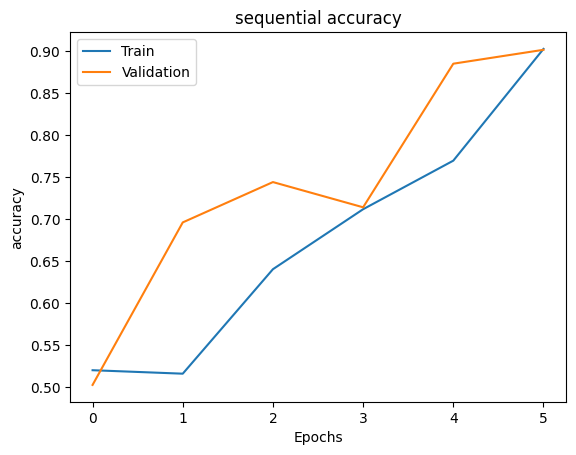

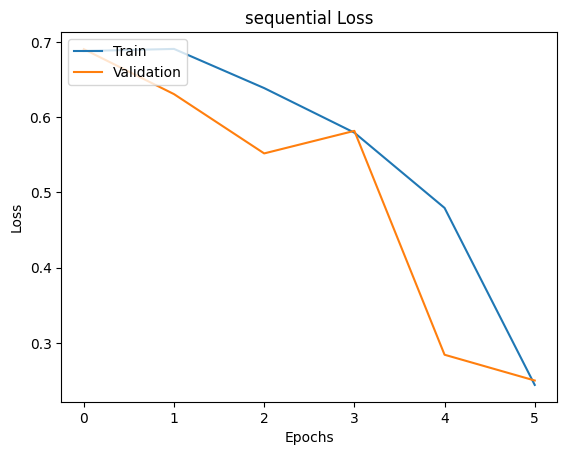

In [33]:
model_LSTM_performance(model.name, lstm_model_history, 'accuracy', 'loss')


Sur les résultats obtenus du graphe, on a une accuracy qui est égale à **0.90** sur l'accuracy sequentielle. Ce qui est une bonne performance. Et on note une diminution de la loss sequentielle.